In [1]:
# 초기설정
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

# What's Cooking? 
### Bright Kim
- ref : https://www.kaggle.com/c/whats-cooking-kernels-only
---

- 그리드써치 시도한 커널 https://www.kaggle.com/andreaschandra/svm-and-gridsearchcv

# 일단 받고보자

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pandas as pd
import json
from pandas.io.json import json_normalize

# Dataset Preparation
print ("Read Dataset ... ")

def jsonRead(path):
    print(path," read now working...")
    with open(path,encoding='utf8') as f: 
        json_info = json.load(f) 
        df = json_normalize(json_info)

    df_re = pd.DataFrame(df['ingredients'])
    df_re['txt']=df.ingredients.str.join(",")
    df['ing']=df_re['txt'].replace(" ","",regex=True)
    ls = []
    for string in list(df['ing']):
        for data in string.split(","):
            ls.append(data)
    print(*ls[:10]," and more... ")
    print("재료수 length : ",len(set(ls))," || total ing_data : ",len(ls))
    return set(ls), df

ls_train, df = jsonRead('train.json')
ls_test, df_test = jsonRead('test.json')

Read Dataset ... 
train.json  read now working...
romainelettuce blackolives grapetomatoes garlic pepper purpleonion seasoning garbanzobeans fetacheesecrumbles plainflour  and more... 
재료수 length :  6692  || total ing_data :  428903
test.json  read now working...
bakingpowder eggs all-purposeflour raisins milk whitesugar sugar eggyolks cornstarch creamoftartar  and more... 
재료수 length :  4476  || total ing_data :  107581


In [3]:
ls_all = set(ls_train | ls_test)
print("train시 적용될 재료의 종류 : ",len(ls_all))

train시 적용될 재료의 종류 :  7114


In [167]:
a = df.iloc[:,0:1]
a.describe()
# 총 39774개의 학습용 데이터, Y값은 20개의 카테고리로 구분된다.

,cuisine
count,39774
unique,20
top,italian
freq,7838


In [4]:
df_t = df.iloc[:,:].copy()
cnt=0
for i in list(ls_all):
    df_t[i] = df_t["ing"].str.contains(i)
    if cnt%100 == 0: print(cnt,end=" ") 
    cnt +=1
df_t.iloc[:,:15]

0 100 200 300 400 500 600 700 800 

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 

,cuisine,id,ingredients,ing,,boneinskinonchickenthigh,eaudevie,dates,lowsaltchickenbroth,glazedpecans,low-fatcottagecheese,blackquinoa,cantonnoodles,sirloinsteak,lemonlimebeverage
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romainelettuce,blackolives,grapetomatoes,garli...",True,False,False,False,False,False,False,False,False,False,False
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plainflour,groundpepper,salt,tomatoes,groundbl...",True,False,False,False,False,False,False,False,False,False,False
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cookingoil,greenchi...",True,False,False,False,False,False,False,False,False,False,False
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetableoil,wheat,salt",True,False,False,False,False,False,False,False,False,False,False
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","blackpepper,shallots,cornflour,cayennepepper,o...",True,False,False,False,False,False,False,False,False,False,False
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge...","plainflour,sugar,butter,eggs,freshgingerroot,s...",True,False,False,False,False,False,False,False,False,False,False
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli...","oliveoil,salt,mediumshrimp,pepper,garlic,chopp...",True,False,False,False,False,False,False,False,False,False,False
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo...","sugar,pistachionuts,whitealmondbark,flour,vani...",True,False,False,False,False,False,False,False,False,False,False
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por...","oliveoil,purpleonion,freshpineapple,pork,pobla...",True,False,False,False,False,False,False,False,False,False,False
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-...","choppedtomatoes,freshbasil,garlic,extra-virgin...",True,False,False,False,False,False,False,False,False,False,False


In [97]:
df_t.iloc[:,4:].describe().T.sort_values('freq', ascending=True).iloc[:20,:]

,count,unique,top,freq
pepper,39774,2,True,20498
oil,39774,2,True,21358
garlic,39774,2,False,21540
mi,39774,2,False,23793
ice,39774,2,False,24538
salt,39774,2,True,24612
red,39774,2,False,27997
onions,39774,2,False,28042
sugar,39774,2,False,28688
oliveoil,39774,2,False,29086


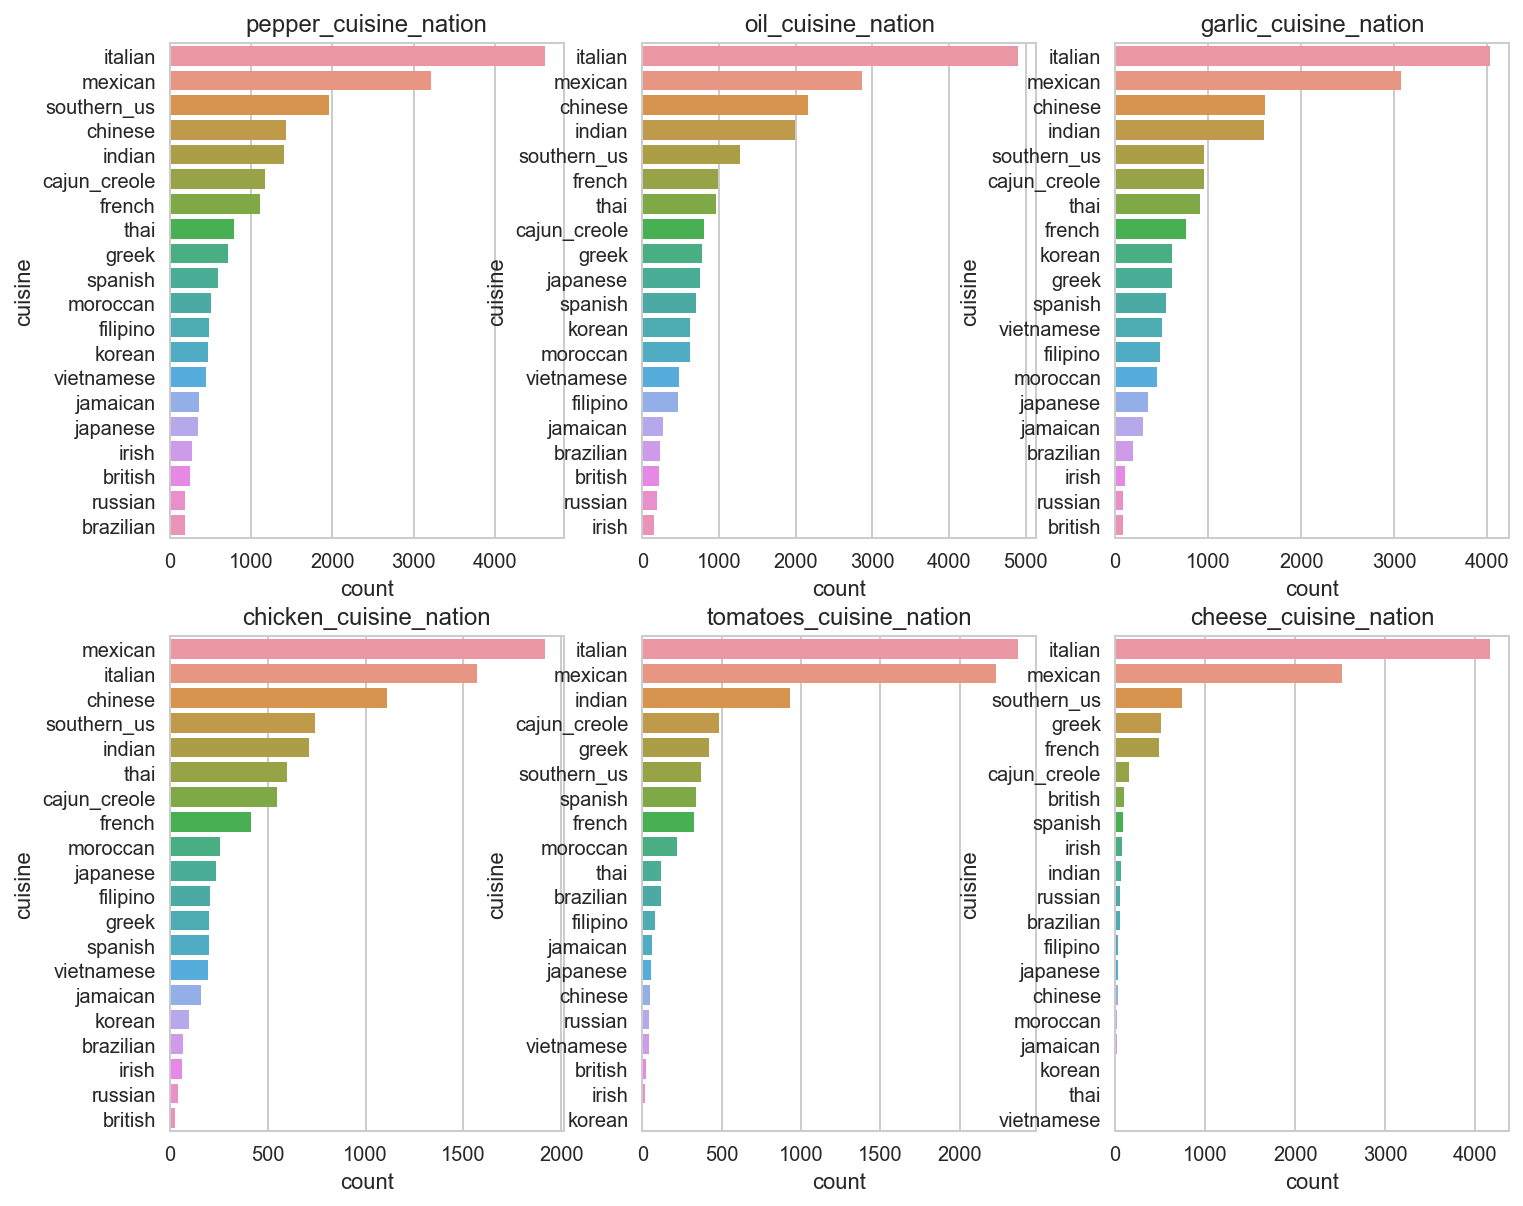

In [147]:
def getPlotEachIngs(ing_name):
    temp = df_t[df_t[ing_name]==True].copy()
    temp = temp[["cuisine","id",ing_name]]
    temp[ing_name] = temp[ing_name].astype(int)
    group_df=temp.groupby(["cuisine"]).size().reset_index(name="count").sort_values('count', ascending=False)
    sns.barplot(data=group_df,x="count",y="cuisine").set_title(ing_name+"_cuisine_nation")

plt.figure(figsize=(12,10))    
plt.subplot(231)    
getPlotEachIngs("pepper")
plt.subplot(232)
getPlotEachIngs("oil")
plt.subplot(233)
getPlotEachIngs("garlic")
plt.subplot(234)
getPlotEachIngs("chicken")
plt.subplot(235)
getPlotEachIngs("tomatoes")
plt.subplot(236)
getPlotEachIngs("cheese")



        cuisine  pepper  count
19      italian       1   4611
18      italian       0   3227
26      mexican       0   3223
27      mexican       1   3215
32  southern_us       0   2363
33  southern_us       1   1957 
length=


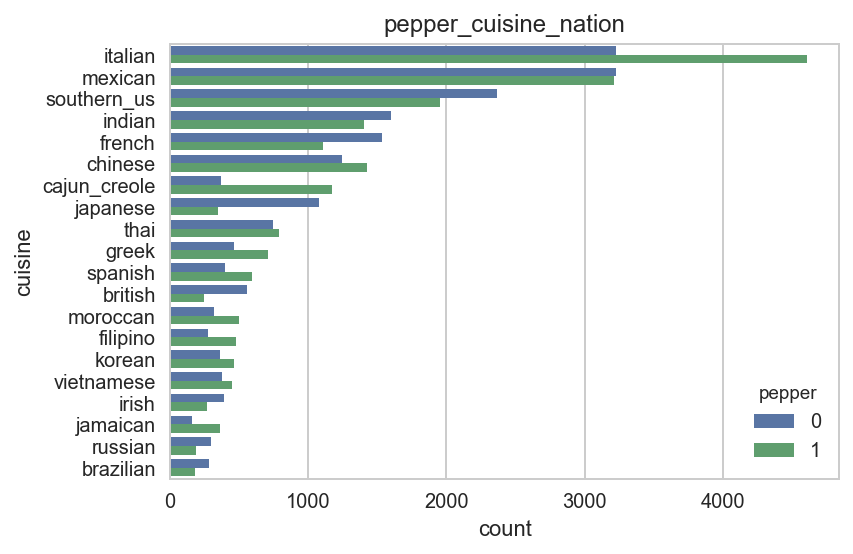

In [161]:
def getPlotEachIngsProba(ing_name):
    temp = df_t.copy()
    temp = temp[["cuisine","id",ing_name]]
    temp[ing_name] = temp[ing_name].astype(int)
    group_df=temp.groupby(["cuisine",ing_name]).size().reset_index(name="count").sort_values('count', ascending=False)
    group_sum=temp.groupby(["cuisine"]).size().reset_index(name="count").sort_values('count', ascending=False)
    print(group_df.head(6),"\nlength=")
    
    for i,nation in enumerate(group_sum["cuisine"].values):
        proba = /*100
        group_df["prob"] = 0
        group_df.prob[group_df["cuisine"]==nation] = proba
    
    sns.barplot(data=group_df,x="count",y="cuisine", hue=ing_name).set_title(ing_name+"_cuisine_nation")

# plt.figure(figsize=(12,10))    
# plt.subplot(231)    
getPlotEachIngsProba("pepper")
# plt.subplot(232)
# getPlotEachIngs("oil")
# plt.subplot(233)
# getPlotEachIngs("garlic")
# plt.subplot(234)
# getPlotEachIngs("chicken")
# plt.subplot(235)
# getPlotEachIngs("tomatoes")
# plt.subplot(236)
# getPlotEachIngs("cheese")

# 음냐... 이거슨 간단하지만 간단치만은 않다 또...
# 일단 모델 돌려봅시다.

In [5]:
#사전조건 설정 ()
train_if = df_t.copy()

In [6]:
# y값 카테고리화
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train_if['cuisine']
le.fit(y)
y= le.transform(y)
y

array([ 6, 16,  4, ...,  8,  3, 13], dtype=int64)

In [30]:
le.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [7]:
df_final_raw = train_if.iloc[:,4:].copy()
print("col_vol:",len(df_final_raw.columns))
df_final = df_final_raw.copy()
df_final.columns = [i for i in range(7114)]
df_final.tail()

col_vol: 7114


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048,7049,7050,7051,7052,7053,7054,7055,7056,7057,7058,7059,7060,7061,7062,7063,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7075,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085,7086,7087,7088,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113
39769,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
39770,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
39771,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

# LightGBM!

model creating. n_esti :  15  max_depth==>, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
model testing...
LGB Model1: CV Mean score: 0.530 --- acuraccy score : 0.530
LGB Model2: CV Mean score: 0.602 --- acuraccy score : 0.606
LGB Model3: CV Mean score: 0.639 --- acuraccy score : 0.649
LGB Model4: CV Mean score: 0.669 --- acuraccy score : 0.683
LGB Model5: CV Mean score: 0.690 --- acuraccy score : 0.712
LGB Model6: CV Mean score: 0.705 --- acuraccy score : 0.731
LGB Model7: CV Mean score: 0.714 --- acuraccy score : 0.743
LGB Model8: CV Mean score: 0.721 --- acuraccy score : 0.750
LGB Model9: CV Mean score: 0.724 --- acuraccy score : 0.753
LGB Model10: CV Mean score: 0.727 --- acuraccy score : 0.757
LGB Model11: CV Mean score: 0.729 --- acuraccy score : 0.758
LGB Model12: CV Mean score: 0.729 --- acuraccy score : 0.758
LGB Model13: CV Mean score: 0.730 --- acuraccy score : 0.759
LGB Model14: CV Mean score: 0.729 --- acuraccy score : 0.757
LGB Model15: CV Mean score: 0.73

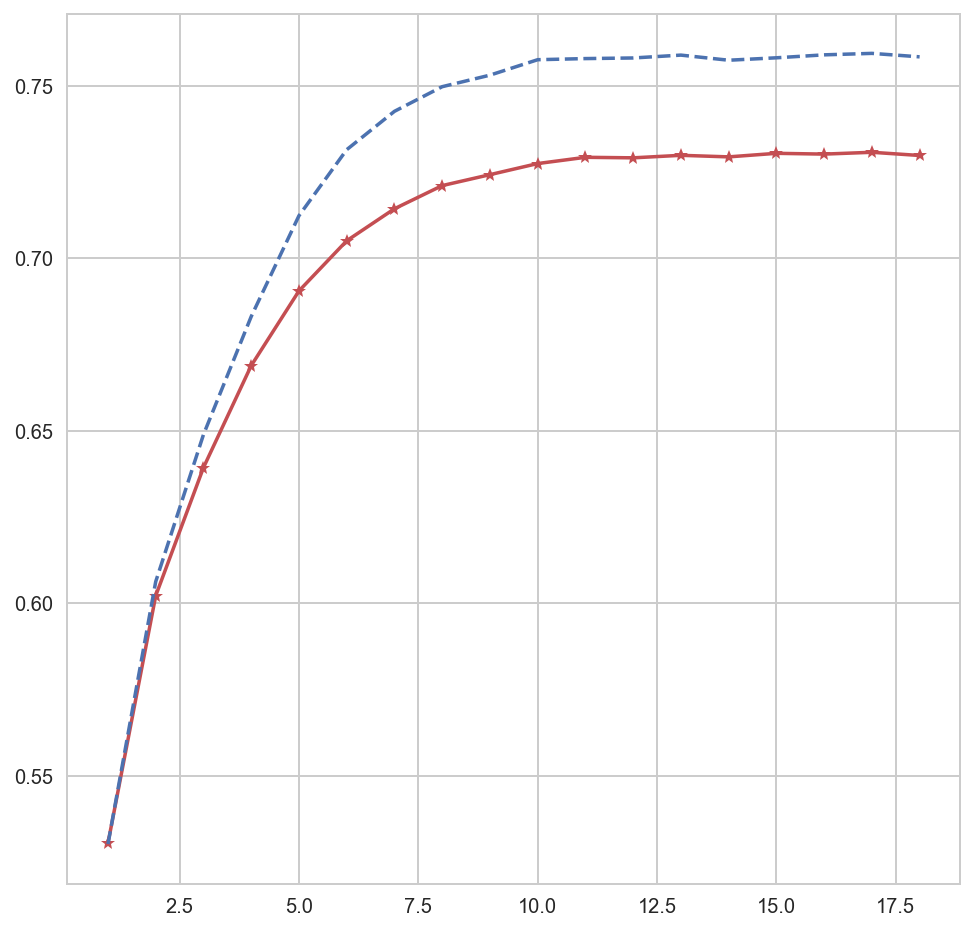

In [190]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 15
print("model creating. n_esti :",n_esti,"| max_depth==>",end="") # max_depth
for i in range(1,19,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = n_esti, objective="multiclass",
                             max_depth=i, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# best_score = cv 0.632 - acc 0.640, nesti = 10, depth = 3

model creating. n_esti : 25 | max_depth==>, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
model testing...
LGB Model1: CV Mean score: 0.548 --- acuraccy score : 0.550
LGB Model2: CV Mean score: 0.618 --- acuraccy score : 0.622
LGB Model3: CV Mean score: 0.656 --- acuraccy score : 0.666
LGB Model4: CV Mean score: 0.685 --- acuraccy score : 0.703
LGB Model5: CV Mean score: 0.705 --- acuraccy score : 0.730
LGB Model6: CV Mean score: 0.718 --- acuraccy score : 0.750
LGB Model7: CV Mean score: 0.726 --- acuraccy score : 0.762
LGB Model8: CV Mean score: 0.733 --- acuraccy score : 0.768
LGB Model9: CV Mean score: 0.737 --- acuraccy score : 0.771
LGB Model10: CV Mean score: 0.739 --- acuraccy score : 0.772
LGB Model11: CV Mean score: 0.741 --- acuraccy score : 0.775
LGB Model12: CV Mean score: 0.742 --- acuraccy score : 0.775
LGB Model13: CV Mean score: 0.742 --- acuraccy score : 0.776
LGB Model14: CV Mean score: 0.742 --- acuraccy score : 0.776
LGB Model15: CV Mean score: 0.74

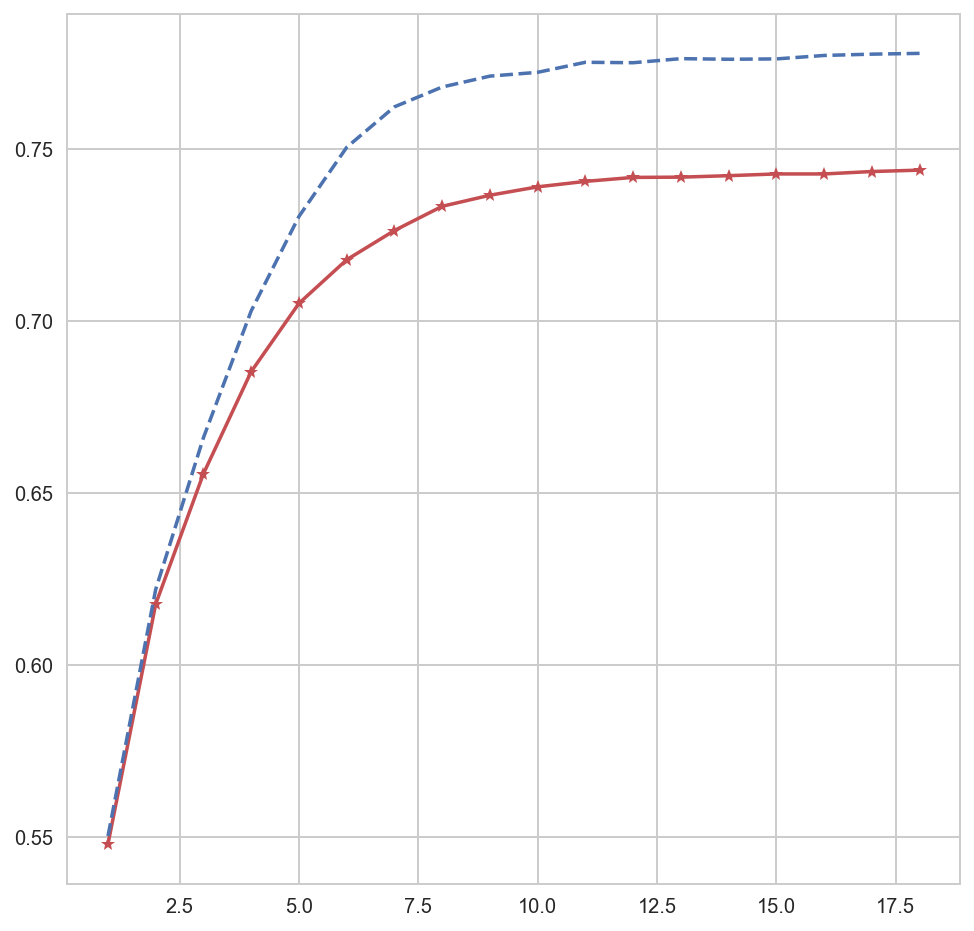

In [191]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 25
print("model creating. n_esti :",n_esti,"| max_depth==>",end="") # max_depth
for i in range(1,19,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = n_esti, objective="multiclass",
                             max_depth=i, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# best_score = cv 0.744 - acc 0.778, nesti = 25, depth = 18

model creating. n_esti : 50 | max_depth==> , 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
model testing...
LGB Model1: CV Mean score: 0.582 --- acuraccy score : 0.584
LGB Model2: CV Mean score: 0.653 --- acuraccy score : 0.659
LGB Model3: CV Mean score: 0.693 --- acuraccy score : 0.710
LGB Model4: CV Mean score: 0.717 --- acuraccy score : 0.743
LGB Model5: CV Mean score: 0.733 --- acuraccy score : 0.768
LGB Model6: CV Mean score: 0.743 --- acuraccy score : 0.788
LGB Model7: CV Mean score: 0.750 --- acuraccy score : 0.799
LGB Model8: CV Mean score: 0.755 --- acuraccy score : 0.804
LGB Model9: CV Mean score: 0.758 --- acuraccy score : 0.809
LGB Model10: CV Mean score: 0.761 --- acuraccy score : 0.810
LGB Model11: CV Mean score: 0.762 --- acuraccy score : 0.812
LGB Model12: CV Mean score: 0.763 --- acuraccy score : 0.812
LGB Model13: CV Mean score: 0.764 --- acuraccy score : 0.814
LGB Model14: CV Mean score: 0.764 --- acuraccy score : 0.813
LGB Model15: CV Mean score: 0.7

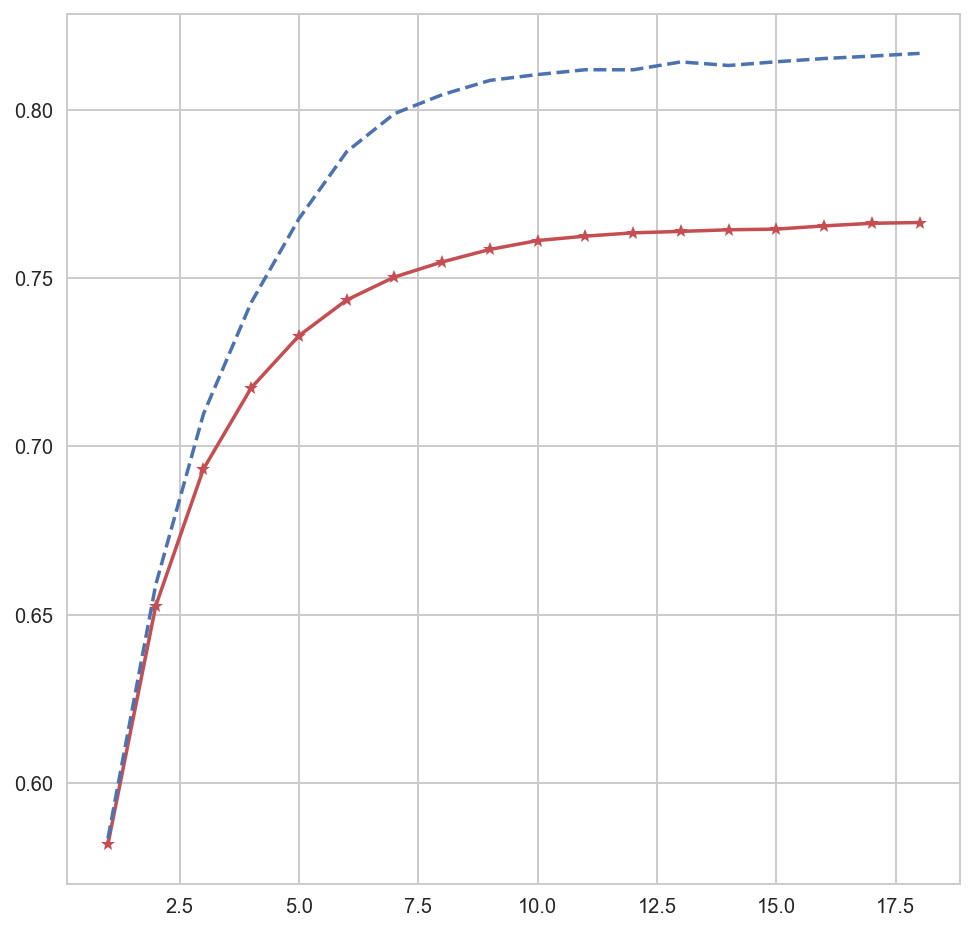

In [193]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 50
print("model creating. n_esti :",n_esti,"| max_depth==> ",end="") # max_depth
for i in range(1,19,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = n_esti, objective="multiclass",
                             max_depth=i, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# 최적부스팅 

model creating. depth:10,| n_estimate==> , 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
model testing...
LGB Model1: CV Mean score: 0.720 --- acuraccy score : 0.747
LGB Model2: CV Mean score: 0.736 --- acuraccy score : 0.767
LGB Model3: CV Mean score: 0.746 --- acuraccy score : 0.783
LGB Model4: CV Mean score: 0.756 --- acuraccy score : 0.799
LGB Model5: CV Mean score: 0.763 --- acuraccy score : 0.812
LGB Model6: CV Mean score: 0.770 --- acuraccy score : 0.825
LGB Model7: CV Mean score: 0.775 --- acuraccy score : 0.836
LGB Model8: CV Mean score: 0.779 --- acuraccy score : 0.845
LGB Model9: CV Mean score: 0.782 --- acuraccy score : 0.854
LGB Model10: CV Mean score: 0.785 --- acuraccy score : 0.864
LGB Model11: CV Mean score: 0.787 --- acuraccy score : 0.872
LGB Model12: CV Mean score: 0.789 --- acuraccy score : 0.879
LGB Model13: CV Mean score: 0.791 --- acuraccy score : 0.886
LGB Model14: CV Mean score: 0.792 --- acuraccy score : 0.892
LGB Model15: CV Mean scor

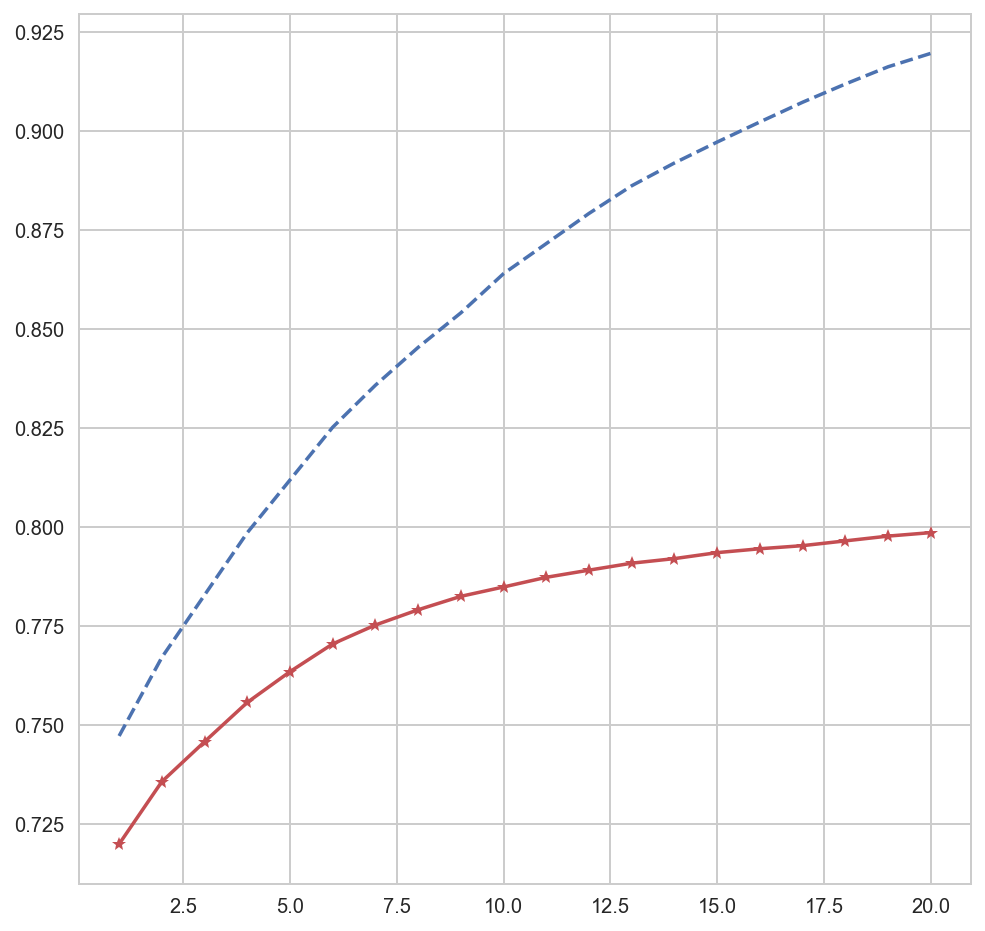

In [194]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 10
print("model creating. depth:12,| n_estimate==> ",end="") # max_depth
for i in range(1,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = n_esti*i, objective="multiclass",
                             max_depth=12, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i*10,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# 최적부스팅 cv 0.799 - acc 0.920 nesti = 200, depth = 12

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 10
print("model creating. depth:12,| n_estimate==> ",end="") # max_depth
for i in range(1,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = n_esti*i, objective="multiclassova",
                             max_depth=12, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i*10,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# 최적부스팅 cv 0.799 - acc 0.920 nesti = 200, depth = 12
# multiclassova방식

model creating. depth:20,| n_estimate==> , 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550
model testing...
LGB Model50: CV Mean score: 0.767 --- acuraccy score : 0.817
LGB Model100: CV Mean score: 0.790 --- acuraccy score : 0.869
LGB Model150: CV Mean score: 0.797 --- acuraccy score : 0.906
LGB Model200: CV Mean score: 0.801 --- acuraccy score : 0.930
LGB Model250: CV Mean score: 0.804 --- acuraccy score : 0.947
LGB Model300: CV Mean score: 0.805 --- acuraccy score : 0.960
LGB Model350: CV Mean score: 0.806 --- acuraccy score : 0.969
LGB Model400: CV Mean score: 0.806 --- acuraccy score : 0.975
LGB Model450: CV Mean score: 0.806 --- acuraccy score : 0.980
LGB Model500: CV Mean score: 0.805 --- acuraccy score : 0.984
LGB Model550: CV Mean score: 0.805 --- acuraccy score : 0.987


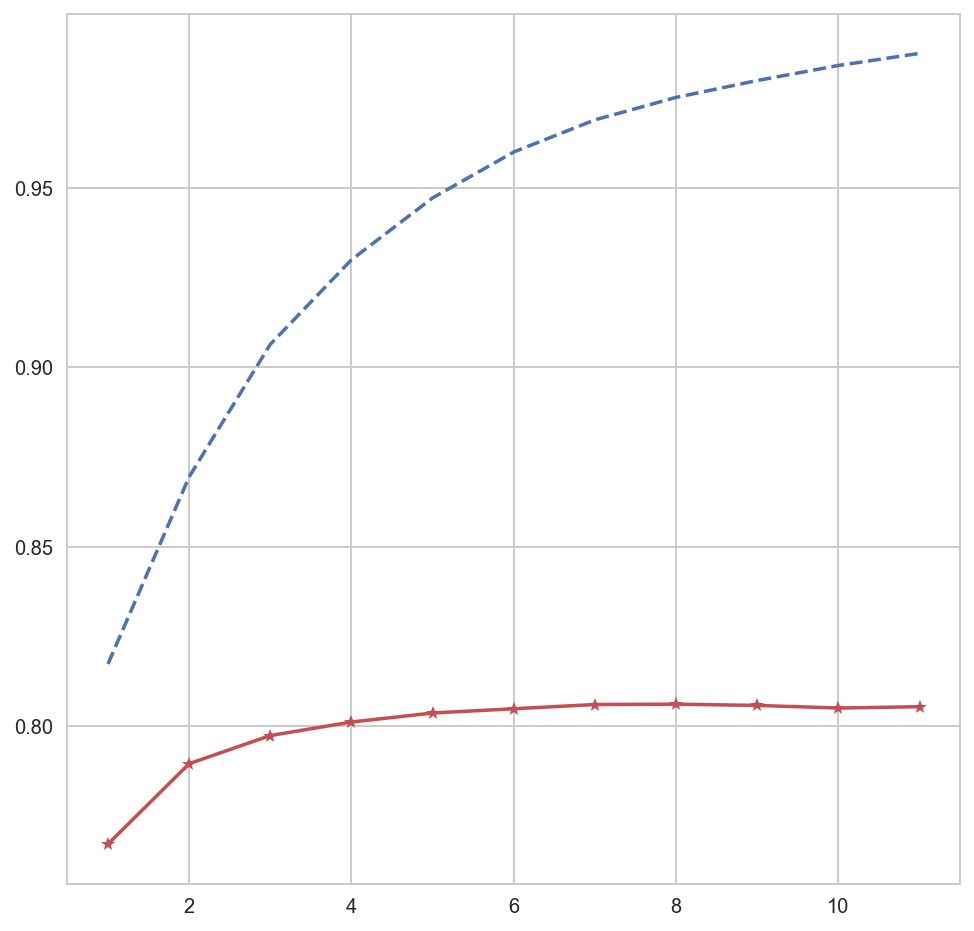

In [32]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 10
print("model creating. depth:20,| n_estimate==> ",end="") # max_depth
for i in range(1,12,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = 50*i, objective="multiclass",
                             max_depth=20, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i*50,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format((i+1)*50,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
# 최대 부스팅 nesti= 1000 depth = 20 --> 0.804
# 최대 부스팅 nesti= 250 & 500 depth = 20 --> 0.803, 0.805
# 추가진행(최적 n-estimates 찾기)

model creating. depth:20,| n_estimate==> , 100
model testing...
LGB Model100: CV Mean score: 0.794 --- acuraccy score : 0.881


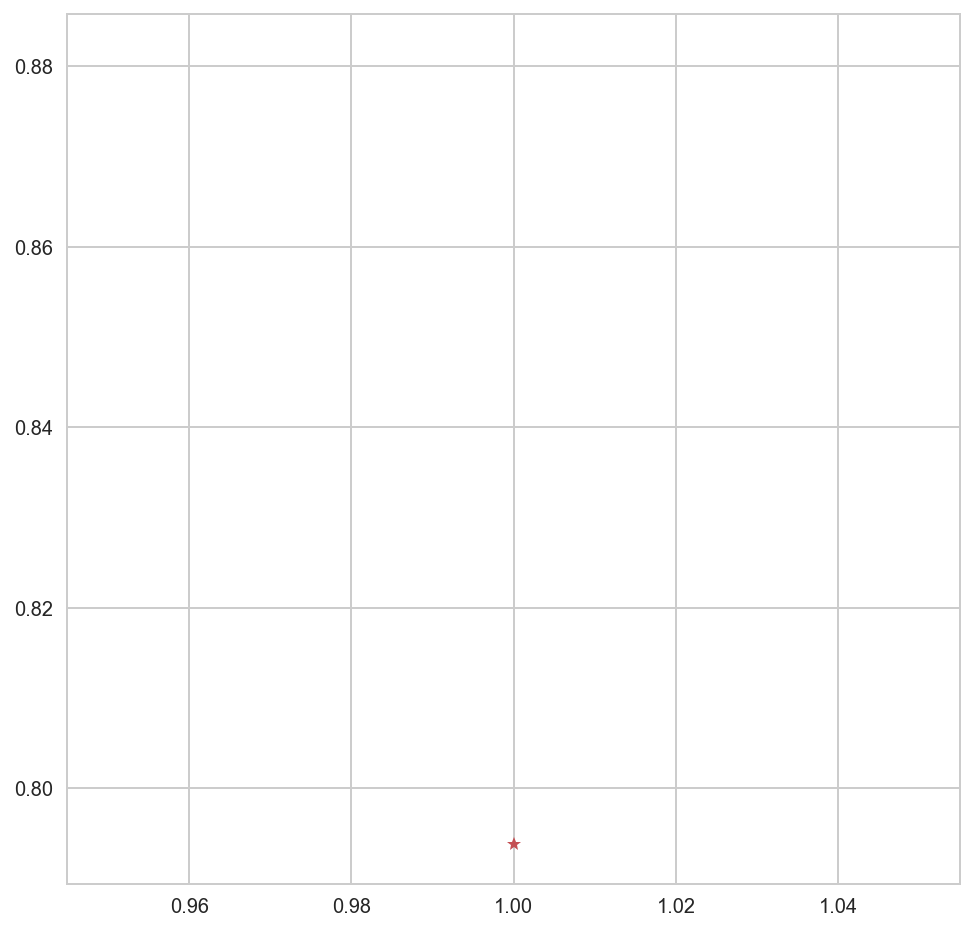

In [33]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# 모델 Generator
n_esti = 10
print("model creating. depth:20,| n_estimate==> ",end="") # max_depth
for i in range(1,2,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators = 100*i, objective="multiclassova",
                             max_depth=20, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i*100,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format((i+1)*100,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()



In [188]:
LGB_model = model_ls[2]

scores = cross_val_score(LGB_model, df_final, y,cv=10)
y_pred = LGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("LGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,y_pred))



LGB Model3: Mean score: 0.632 --- acuraccy score : 0.640
- Confusion_Matrix 
 [[ 117    0    1    2    0   12    1    7    2  139    0    0    1  106
     0    0   51    4   24    0]
 [   0  115    4    4    0   53    3   24   39  226    6    0    0    6
     0    1  321    0    2    0]
 [   1    1  856    6    2   69   10    5    3  327    8    1    0   65
     0    1  187    4    0    0]
 [   9    3    8 2164   11   16    1    9    3  215    0   22   46   56
     0    0   59    0   32   19]
 [  11    1    3  184  149   14    0    5    7  157    0    4    7   30
     0    0   54    3   64   62]
 [   4    4   13    7    3  605    6   23   27 1282   13    4    1   20
     7   16  587   21    3    0]
 [   0    0    2    4    1   13  507    7    2  508    1    0    6   23
    18   12   69    0    2    0]
 [   2    0    0   13    3    5   15 2329    5  204    2    0    2  274
    17    3   93    1   33    2]
 [   0   11    4    6    1   35    0    5  179  130    4    0    2    8
     0    

C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 20, does not match size of target_names, 5
  .format(len(labels), len(target_names))


In [ ]:
param_test ={'num_leaves': sp_randint(6, 100), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': np.linspace( 1e-10,   100 ),
             'reg_lambda':  np.linspace( 1e-10,   100 ),
             }

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
        
            'verbose': 100,
            }

# clf = LGBMClassifier( 
#     max_depth=-1, random_state=314, silent=True, objective = 'binary',  metric='binary_logloss', n_jobs=-1, n_estimators=5000)
LGB = LGBMClassifier( 
    max_depth=-1, random_state=0, silent=True, objective = 'multiclass', n_jobs=-1, n_estimators=10)


gs = RandomizedSearchCV(
    
    estimator=LGB, param_distributions=param_test, 
    n_iter= 1000,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True,
    n_jobs=-1)

gs.fit(df_final, y)
# gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} \n'.format(gs.best_score_, gs.best_params_))

# submission파일 

In [19]:
df_y = df_test.iloc[:,:].copy()
cnt=0
for i in list(ls_all):
    df_y[i] = df_y["ing"].str.contains(i)
    if cnt%100 == 0: print(cnt,end=" ") 
    cnt +=1

df_tfinal_raw = df_y.iloc[:,3:].copy()
print("col_vol:",len(df_tfinal_raw.columns))
df_tfinal = df_tfinal_raw.copy()
df_tfinal.columns = [i for i in range(7114)]
df_tfinal.tail()

col_vol: 7114


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048,7049,7050,7051,7052,7053,7054,7055,7056,7057,7058,7059,7060,7061,7062,7063,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7075,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085,7086,7087,7088,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113
9939,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9940,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9941,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [20]:
y_pred= model_ls[0].predict(df_tfinal)

y_result = le.inverse_transform(y_pred)
y_result

array(['irish', 'southern_us', 'italian', ..., 'italian', 'southern_us',
       'mexican'], dtype=object)

In [25]:
list(y_result)

['irish',
 'southern_us',
 'italian',
 'cajun_creole',
 'italian',
 'southern_us',
 'southern_us',
 'chinese',
 'mexican',
 'british',
 'italian',
 'greek',
 'indian',
 'italian',
 'british',
 'italian',
 'mexican',
 'southern_us',
 'mexican',
 'southern_us',
 'japanese',
 'indian',
 'irish',
 'vietnamese',
 'italian',
 'southern_us',
 'vietnamese',
 'korean',
 'italian',
 'southern_us',
 'mexican',
 'thai',
 'indian',
 'japanese',
 'chinese',
 'mexican',
 'russian',
 'indian',
 'indian',
 'cajun_creole',
 'cajun_creole',
 'chinese',
 'french',
 'mexican',
 'italian',
 'italian',
 'spanish',
 'indian',
 'vietnamese',
 'chinese',
 'italian',
 'thai',
 'indian',
 'italian',
 'italian',
 'chinese',
 'italian',
 'japanese',
 'chinese',
 'cajun_creole',
 'french',
 'mexican',
 'filipino',
 'korean',
 'mexican',
 'greek',
 'filipino',
 'thai',
 'italian',
 'italian',
 'italian',
 'indian',
 'thai',
 'vietnamese',
 'indian',
 'japanese',
 'indian',
 'mexican',
 'southern_us',
 'greek',
 'chin

In [23]:
Final_data = pd.DataFrame(df_y["id"], columns=['id'])

Final_data["cuisine"] = y_result
Final_data.tail()
len(df_y['id'])

9944

In [24]:
Final_data.to_csv("submission01_LightGBM_nesti1000_depth20.csv",index=False)